SECTION 1: INITIAL CODE

      input1    input2    output
0   0.665800  0.123969  0.538996
1   0.877791  0.778628  0.420586
2   0.142699  0.349005 -0.065624
3   0.845275  0.711120  0.293993
4   0.454647  0.290455  0.214965
5   0.577713  0.771973  0.023106
6   0.438166  0.685018  0.244619
7   0.341750  0.028698  0.038749
8   0.338648  0.213867 -0.013858
9   0.702637  0.926564  0.611205
10  0.331626  0.080499 -0.029954
11  0.100533  0.477595  0.083120
12  0.677932  0.873704  0.561143
13  0.134956  0.521158  0.013477
14  0.537156  0.244715  0.389944
15  0.659128  0.630642  0.422018
16  0.470452  0.533768  0.586957
17  0.721202  0.364506  0.569550
18  0.722734  0.438018  0.694832
19  0.240668  0.141229  0.033768
20  0.396767  0.538817  0.098811
21  0.200000  0.800000 -0.005837
22  0.800000  0.200000  0.052955
23  0.793314  0.755414  0.166014
24  0.359466  0.857625 -0.039079
25  0.327792  0.196618 -0.046838
26  0.858888  0.709529  0.470411
27  0.826748  0.767465  0.262469
28  0.520960  0.248634  0.487483
29  0.6676

C:\Users\sabri\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Log-Likelihood of the model: -24183.854006

|   iter    |  target   |  input1   |  input2   |
-------------------------------------------------
| 22        | 0.5315    | 0.5643    | 0.2068    |
Iteration 17:
Best input: {'input1': 0.5643017249421167, 'input2': 0.2067904111920431}
Best predicted output: 0.5315481488567002
Log-Likelihood of the model: -24178.140875

|   iter    |  target   |  input1   |  input2   |
-------------------------------------------------
| 23        | 0.5312    | 0.5614    | 0.2037    |
Iteration 18:
Best input: {'input1': 0.5643017249421167, 'input2': 0.2067904111920431}
Best predicted output: 0.5315481488567002
Log-Likelihood of the model: -24172.328409

|   iter    |  target   |  input1   |  input2   |
-------------------------------------------------
| 24        | 0.531     | 0.5633    | 0.213     |
Iteration 19:
Best input: {'input1': 0.5643017249421167, 'input2': 0.2067904111920431}
Best predicted output: 0.5315481488567002
Log-Likelihood of the model: -2

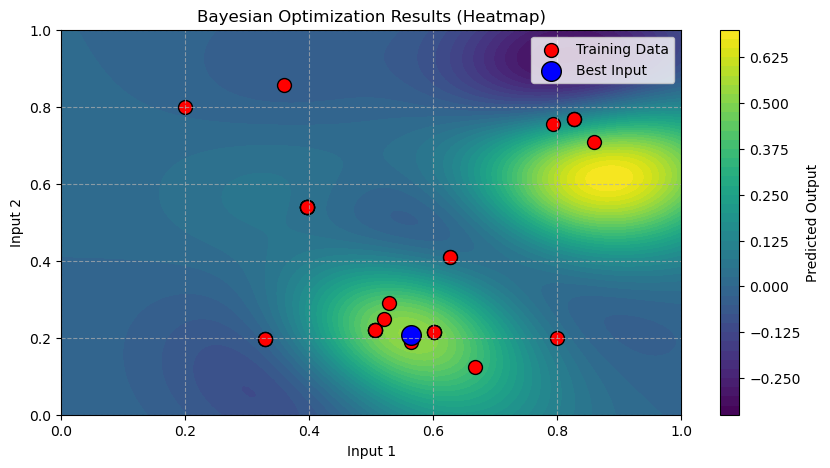

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from bayes_opt import BayesianOptimization

###################################
# this piece of code was provided by a team mate to help automatically extract the queries and observation and remove any duplicates
function = 2
# Read the files
X_init = np.load("initial_inputs.npy")
y_init = np.load("initial_outputs.npy")
queries_file = "queries.txt"
observations_file = "observations.txt"

# Read queries data
import ast
queries_data = []
with open(queries_file, 'r') as f:
    for line in f:
        line = line.replace('array(', 'np.array(')
        queries_data.append(eval(line.strip()))

# Read observations data
observations_data = []
with open(observations_file, 'r') as f:
    for line in f:
        observations_data.append(eval(line.strip()))

# Extract the specified sub-arrays from queries
X = np.array([q[function - 1] for q in queries_data], dtype='float64')
y = np.array([o[function - 1] for o in observations_data])

# Find and remove duplicates
unique_indices = []
seen = set()
for i, x in enumerate(X):
    x_tuple = tuple(x)  # Convert to tuple for hashability
    if x_tuple not in seen:
        seen.add(x_tuple)
        unique_indices.append(i)

# Keep only unique queries and observations
X_unique = np.concatenate((X_init, X[unique_indices]))
y_unique = np.concatenate((y_init, y[unique_indices]))
queries_unique = [queries_data[i] for i in unique_indices]
observations_unique = [observations_data[i] for i in unique_indices]

# Save cleaned data to new files
with open("queries_unique.txt", "w") as f:
    for query in queries_unique:
        f.write(str(query) + "\n")

with open("observations_unique.txt", "w") as f:
    for obs in observations_unique:
        f.write(str(obs) + "\n")

# Save cleaned numpy arrays
np.save("initial_inputs_unique.npy", X_unique)
np.save("initial_outputs_unique.npy", y_unique)

###############################

# Create a DataFrame from the inputs with specified column names
df_inputs = pd.DataFrame(X_unique, columns=['input1', 'input2'])

# Create a DataFrame for the outputs
df_outputs = pd.DataFrame(y_unique, columns=['output'])

# Concatenate the inputs and outputs DataFrames
data = pd.concat([df_inputs, df_outputs], axis=1)

# Display the resulting DataFrame
print(data)

##############################

# Save the DataFrame to an Excel file
data.to_excel('F2_data.xlsx', index=False)  

print("Data saved ")

################################

# Scale the input features initially
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define a custom kernel to improve stability
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize the GP with the custom kernel and more restarts
gp = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=20,
    alpha=1e-6  # Add small noise to stabilize computation
)

#################################

# Fit the model to the initial scaled data
gp.fit(X_scaled, y)

################################

# Define the objective function for Bayesian Optimization
def objective_function(input1, input2):
    input_data = np.array([[input1, input2]])
    input_data_scaled = scaler.transform(input_data)  # Scale the input
    prediction = gp.predict(input_data_scaled)
    return prediction[0]  # Return the predicted output

# Set the bounds for the input space
pbounds = {'input1': (0, 1), 'input2': (0, 1)}

###############################

# Create a Bayesian Optimization object
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=1,
)

################################

# Number of iterations for optimization
n_iterations = 20

# Loop for Bayesian Optimization
for i in range(n_iterations):
    # Perform the optimization
    optimizer.maximize(init_points=5 if i == 0 else 0, n_iter=1)

    # Get the best result from the current iteration
    best_result = optimizer.max
    print(f"Iteration {i + 1}:")
    print(f"Best input: {best_result['params']}")
    print(f"Best predicted output: {best_result['target']}")

    # Update the GP model with the new best point
    new_input = np.array([[best_result['params']['input1'], best_result['params']['input2']]])
    new_output = best_result['target']

    # Append the new data point to the existing data (unscaled)
    X = np.vstack((X, new_input))
    y = np.append(y, new_output)

    # Rescale the entire updated dataset before refitting
    X_scaled = scaler.fit_transform(X)  # Refit scaler to the updated X

    # Refit the GP model with the updated scaled data
    gp.fit(X_scaled, y)

    # Print the log-likelihood of the updated model
    log_likelihood = gp.log_marginal_likelihood(gp.kernel_.theta)
    print(f"Log-Likelihood of the model: {log_likelihood:.6f}\n")

    #######################################

    # Final visualization of the results as a heatmap
plt.figure(figsize=(10, 5))

# Create a grid of points for the heatmap
x1 = np.linspace(0, 1, 100)  # 100 points along Input 1
x2 = np.linspace(0, 1, 100)  # 100 points along Input 2
X1, X2 = np.meshgrid(x1, x2)  # Create a 2D grid
grid_points = np.c_[X1.ravel(), X2.ravel()]  # Flatten into a list of [input1, input2] pairs

# Scale the grid points using the same scaler
grid_points_scaled = scaler.transform(grid_points)

# Predict the output over the grid using the GP model
predictions = gp.predict(grid_points_scaled)
predictions = predictions.reshape(X1.shape)  # Reshape back to 2D for plotting

# Plot the heatmap
plt.contourf(X1, X2, predictions, levels=50, cmap='viridis')  # Filled contour plot
plt.colorbar(label='Predicted Output')  # Add a colorbar

# Overlay the training data and best input as scatter points
plt.scatter(X[:, 0], X[:, 1], c='red', label='Training Data', s=100, edgecolor='black')
plt.scatter(best_result['params']['input1'], best_result['params']['input2'], 
            c='blue', label='Best Input', s=200, edgecolor='black')

# Customize the plot
plt.title('Bayesian Optimization Results (Heatmap)')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#########################################




SECTION 2: CODE MODIFICATION

SECTION 3: FINAL RESULT

      input1    input2    output
0   0.665800  0.123969  0.538996
1   0.877791  0.778628  0.420586
2   0.142699  0.349005 -0.065624
3   0.845275  0.711120  0.293993
4   0.454647  0.290455  0.214965
5   0.577713  0.771973  0.023106
6   0.438166  0.685018  0.244619
7   0.341750  0.028698  0.038749
8   0.338648  0.213867 -0.013858
9   0.702637  0.926564  0.611205
10  0.331626  0.080499 -0.029954
11  0.100533  0.477595  0.083120
12  0.677932  0.873704  0.561143
13  0.134956  0.521158  0.013477
14  0.537156  0.244715  0.389944
15  0.659128  0.630642  0.422018
16  0.470452  0.533768  0.586957
17  0.721202  0.364506  0.569550
18  0.722734  0.438018  0.694832
19  0.240668  0.141229  0.033768
20  0.396767  0.538817  0.098811
21  0.200000  0.800000 -0.005837
22  0.800000  0.200000  0.052955
23  0.793314  0.755414  0.166014
24  0.359466  0.857625 -0.039079
25  0.327792  0.196618 -0.046838
26  0.858888  0.709529  0.470411
27  0.826748  0.767465  0.262469
28  0.520960  0.248634  0.487483
29  0.6676

C:\Users\sabri\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Output values from provided data:
Data point 0: 0.538996
Data point 1: 0.420586
Data point 2: -0.065624
Data point 3: 0.293993
Data point 4: 0.214965
Data point 5: 0.023106
Data point 6: 0.244619
Data point 7: 0.038749
Data point 8: -0.013858
Data point 9: 0.611205
Data point 10: -0.029954
Data point 11: 0.083120
Data point 12: 0.561143
Data point 13: 0.013477
Data point 14: 0.389944
Data point 15: 0.422018
Data point 16: 0.586957
Data point 17: 0.569550
Data point 18: 0.694832
Data point 19: 0.033768
Data point 20: 0.098811
Data point 21: -0.005837
Data point 22: 0.052955
Data point 23: 0.166014
Data point 24: -0.039079
Data point 25: -0.046838
Data point 26: 0.470411
Data point 27: 0.262469
Data point 28: 0.487483
Data point 29: 0.364484

Best point from provided dataset:
Best input1: 0.722734
Best input2: 0.438018
Best output (log-likelihood): 0.694832

Best point from optimization:
Best input1: 0.796543
Best input2: 0.183435
Best predicted output (log-likelihood): 0.012650

Next po

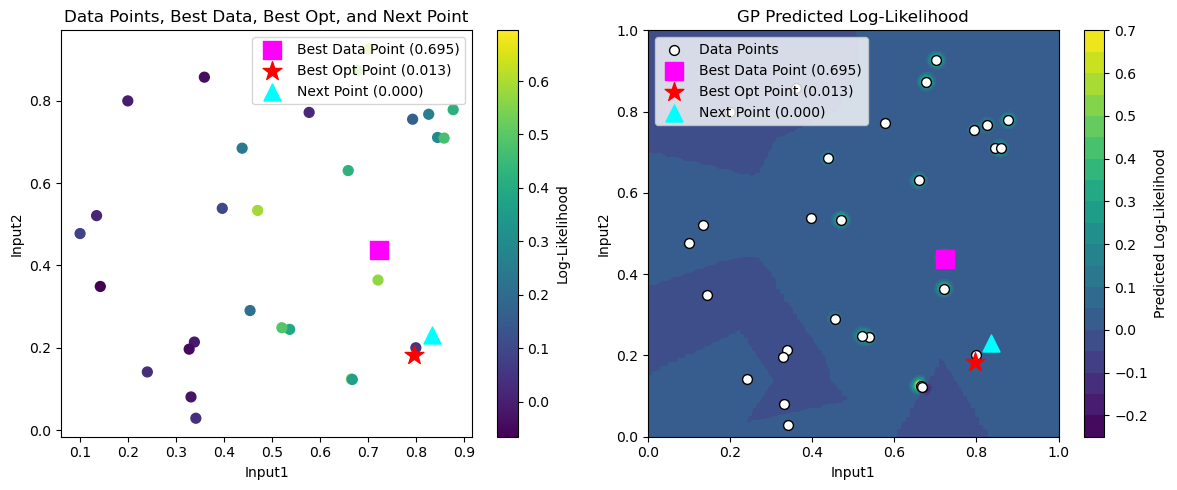

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from bayes_opt import BayesianOptimization

##############################

# the following code was provided by a team mate to remove duplicates from the queries and observations
function = 2
# Read the files
X_init = np.load("initial_inputs.npy")
y_init = np.load("initial_outputs.npy")
queries_file = "queries.txt"
observations_file = "observations.txt"

# Read queries data
import ast
queries_data = []
with open(queries_file, 'r') as f:
    for line in f:
        line = line.replace('array(', 'np.array(')
        queries_data.append(eval(line.strip()))

# Read observations data
observations_data = []
with open(observations_file, 'r') as f:
    for line in f:
        observations_data.append(eval(line.strip()))

# Extract the specified sub-arrays from queries
X = np.array([q[function - 1] for q in queries_data], dtype='float64')
y = np.array([o[function - 1] for o in observations_data])

# Find and remove duplicates
unique_indices = []
seen = set()
for i, x in enumerate(X):
    x_tuple = tuple(x)  # Convert to tuple for hashability
    if x_tuple not in seen:
        seen.add(x_tuple)
        unique_indices.append(i)

# Keep only unique queries and observations
X_unique = np.concatenate((X_init, X[unique_indices]))
y_unique = np.concatenate((y_init, y[unique_indices]))
queries_unique = [queries_data[i] for i in unique_indices]
observations_unique = [observations_data[i] for i in unique_indices]

# Save cleaned data to new files
with open("queries_unique.txt", "w") as f:
    for query in queries_unique:
        f.write(str(query) + "\n")

with open("observations_unique.txt", "w") as f:
    for obs in observations_unique:
        f.write(str(obs) + "\n")

# Save cleaned numpy arrays
np.save("initial_inputs_unique.npy", X_unique)
np.save("initial_outputs_unique.npy", y_unique)

#################################

# Create a DataFrame from the inputs with specified column names
df_inputs = pd.DataFrame(X_unique, columns=['input1', 'input2'])

# Create a DataFrame for the outputs
df_outputs = pd.DataFrame(y_unique, columns=['output'])

# Concatenate the inputs and outputs DataFrames
data = pd.concat([df_inputs, df_outputs], axis=1)

# Display the resulting DataFrame
print(data)

################################

from skopt import gp_minimize
from skopt.space import Real

# Assume data is a pandas DataFrame with columns 'input1', 'input2', 'output'

# Prepare the data
X = data[['input1', 'input2']].values
y = data['output'].values

# Find the best point from the provided dataset
best_data_index = np.argmax(data['output'])
best_data_input1 = data['input1'].iloc[best_data_index]
best_data_input2 = data['input2'].iloc[best_data_index]
best_data_output = data['output'].iloc[best_data_index]

# Fit a Gaussian Process Regressor as the surrogate model
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X, y)

# Define the objective function to maximize (negative for minimization)
def objective(x):
    return -gp.predict([x])[0]  # Negative because gp_minimize minimizes

# Define the search space for input1 and input2
space = [
    Real(0.0, 1.0, name='input1'),
    Real(0.0, 1.0, name='input2')
]

# Run Bayesian optimization for 21 calls to get the 21st point
result = gp_minimize(
    objective,
    space,
    n_calls=21,  # One more than previous 20 to get the next point
    n_initial_points=10,
    random_state=42,
    acq_func='EI',  # Expected Improvement
    n_jobs=1
)

# Extract the best results from optimization
best_opt_index = np.argmin(result.func_vals)  # Index of the best (minimized) objective
best_opt_inputs = result.x_iters[best_opt_index]
best_opt_log_likelihood = -result.func_vals[best_opt_index]  # Negate to get log-likelihood

# Extract the next coordinates to test (the 21st point)
next_coords = result.x_iters[-1]
next_predicted_outcome = -result.func_vals[-1]  # Negate to get log-likelihood

# Print the output values from the provided data
print("Output values from provided data:")
for i, output in enumerate(data['output']):
    print(f"Data point {i}: {output:.6f}")

# Print the best point from the provided dataset
print("\nBest point from provided dataset:")
print(f"Best input1: {best_data_input1:.6f}")
print(f"Best input2: {best_data_input2:.6f}")
print(f"Best output (log-likelihood): {best_data_output:.6f}")

# Print the best results from optimization
print("\nBest point from optimization:")
print(f"Best input1: {best_opt_inputs[0]:.6f}")
print(f"Best input2: {best_opt_inputs[1]:.6f}")
print(f"Best predicted output (log-likelihood): {best_opt_log_likelihood:.6f}")

# Print the next coordinates and expected output
print("\nNext point to test:")
print(f"input1: {next_coords[0]:.6f}")
print(f"input2: {next_coords[1]:.6f}")
print(f"Expected output (log-likelihood): {next_predicted_outcome:.6f}")

# --- Plotting ---
# Create a grid for contour plot
n_points = 100
x1 = np.linspace(0, 1, n_points)
x2 = np.linspace(0, 1, n_points)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.vstack([X1.ravel(), X2.ravel()]).T
y_pred, _ = gp.predict(X_grid, return_std=True)
y_pred = y_pred.reshape(n_points, n_points)

# Create subplots
plt.figure(figsize=(12, 5))

# 1. Scatter plot of data with best and next points
plt.subplot(1, 2, 1)
scatter = plt.scatter(data['input1'], data['input2'], c=data['output'], cmap='viridis', s=50)
plt.scatter(best_data_input1, best_data_input2, c='magenta', marker='s', s=150, label=f'Best Data Point ({best_data_output:.3f})')
plt.scatter(best_opt_inputs[0], best_opt_inputs[1], c='red', marker='*', s=200, label=f'Best Opt Point ({best_opt_log_likelihood:.3f})')
plt.scatter(next_coords[0], next_coords[1], c='cyan', marker='^', s=150, label=f'Next Point ({next_predicted_outcome:.3f})')
plt.colorbar(scatter, label='Log-Likelihood')
plt.xlabel('Input1')
plt.ylabel('Input2')
plt.title('Data Points, Best Data, Best Opt, and Next Point')
plt.legend()

# 2. Contour plot of GP predictions
plt.subplot(1, 2, 2)
contour = plt.contourf(X1, X2, y_pred, levels=20, cmap='viridis')
plt.scatter(data['input1'], data['input2'], c='white', edgecolors='black', s=50, label='Data Points')
plt.scatter(best_data_input1, best_data_input2, c='magenta', marker='s', s=150, label=f'Best Data Point ({best_data_output:.3f})')
plt.scatter(best_opt_inputs[0], best_opt_inputs[1], c='red', marker='*', s=200, label=f'Best Opt Point ({best_opt_log_likelihood:.3f})')
plt.scatter(next_coords[0], next_coords[1], c='cyan', marker='^', s=150, label=f'Next Point ({next_predicted_outcome:.3f})')
plt.colorbar(contour, label='Predicted Log-Likelihood')
plt.xlabel('Input1')
plt.ylabel('Input2')
plt.title('GP Predicted Log-Likelihood')
plt.legend()

plt.tight_layout()
plt.show()
